# Sarcasm Detector

## Get and Load Data

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [ ]:
!gdown --id 1ytPDo88FEC2ArOjdqErAiarAZBNJzEJz

In [ ]:
import pandas as pd

df = pd.read_json('./SarcasmDetect.json', lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


## Remove all records with no headline text

In [ ]:
df = df[df['headline'] != '']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 894.3+ KB


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import tensorflow as tf
import tensorflow_hub as hub
import nltk


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm

### Check Imbalance

In [ ]:
df['is_sarcastic'].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

In [ ]:
X = pd.DataFrame(df['headline'])
X

,headline
0,thirtysomething scientists unveil doomsday clo...
1,dem rep. totally nails why congress is falling...
2,eat your veggies: 9 deliciously different recipes
3,inclement weather prevents liar from getting t...
4,mother comes pretty close to using word 'strea...
...,...
28614,jews to celebrate rosh hashasha or something
28615,internal affairs investigator disappointed con...
28616,the most beautiful acceptance speech this week...
28617,mars probe destroyed by orbiting spielberg-gat...


### Build Train and Test datasets

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, df['is_sarcastic'], test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((20033, 1), (8586, 1))

### Text Pre-processing

In [ ]:
import nltk
import contractions
import re
import tqdm


def normalize_document(doc):
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', ' ', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()

    return doc

def normalize_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        norm_doc = normalize_document(doc)
        norm_docs.append(norm_doc)

    return norm_docs

In [ ]:
X_train['Clean Headline'] = normalize_corpus(X_train['headline'].values)
X_test['Clean Headline'] = normalize_corpus(X_test['headline'].values)

100%|██████████| 8586/8586 [00:00<00:00, 62264.40it/s]


### Baseline Model: BOW TFIDF + Logistic Regression

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=False, min_df=2, max_df=1.0)

cv_train_features = cv.fit_transform(X_train['Clean Headline'])
cv_test_features = cv.transform(X_test['Clean Headline'])
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)

BOW model:> Train features shape: (20033, 12114)  Test features shape: (8586, 12114)


In [ ]:
%%time

# Logistic Regression model on BOW features
from sklearn.linear_model import LogisticRegression

# instantiate model
lr = LogisticRegression(penalty='l2', max_iter=500, C=1, solver='lbfgs', random_state=42)

# train model
lr.fit(cv_train_features, y_train)

# predict on test data
lr_bow_predictions = lr.predict(cv_test_features)

CPU times: user 1.11 s, sys: 3.63 s, total: 4.74 s
Wall time: 1.39 s


In [ ]:
print("Accuracy: %.2f%%" % (accuracy_score(y_test, lr_bow_predictions)*100))
print(classification_report(y_test, lr_bow_predictions))
pd.DataFrame(confusion_matrix(y_test, lr_bow_predictions))

Accuracy: 83.23%
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      4455
           1       0.83      0.82      0.82      4131

    accuracy                           0.83      8586
   macro avg       0.83      0.83      0.83      8586
weighted avg       0.83      0.83      0.83      8586



,0,1
0,3772,683
1,757,3374


### FastText Embeddings + CNN

In [ ]:
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(X_train['Clean Headline'])
t.word_index['<PAD>'] = 0

In [ ]:
train_sequences = t.texts_to_sequences(X_train['Clean Headline'])
test_sequences = t.texts_to_sequences(X_test['Clean Headline'])

In [ ]:
X_train['Clean_Headline_length']

12170    10
28552     9
6883      8
28387    11
12932    21
         ..
21575     9
5390     12
860       8
15795     8
23654     9
Name: Clean_Headline_length, Length: 20033, dtype: int64

In [ ]:
import matplotlib.pyplot as plt

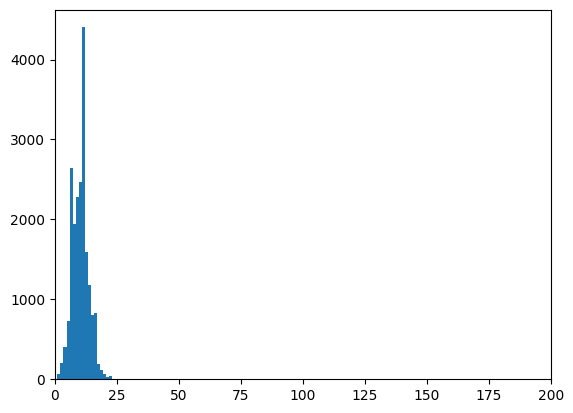

In [ ]:
%matplotlib inline
X_train['Clean_Headline_length'] = X_train['Clean Headline'].apply(lambda x: len(x.split()))
plt.hist(X_train['Clean_Headline_length'].values, bins=30)
plt.xlim([0, 200])
plt.show()

In [ ]:
plt.hist([1,1,24,5,4,3])

(array([3., 2., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 1. ,  3.3,  5.6,  7.9, 10.2, 12.5, 14.8, 17.1, 19.4, 21.7, 24. ]),
 <BarContainer object of 10 artists>)

In [ ]:
MAX_SEQUENCE_LENGTH = 40

# pad dataset to a maximum review length in words
X_train_pad = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test_pad = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train_pad.shape, X_test_pad.shape

((20033, 40), (8586, 40))

In [ ]:
VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 300
EPOCHS=100
BATCH_SIZE=128

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip

--2023-06-23 08:00:29--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.8.19, 13.35.8.51, 13.35.8.35, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.8.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5828358084 (5.4G) [application/zip]
Saving to: ‘crawl-300d-2M-subword.zip.1’

crawl-300d-2M-subwo 100%[===================>]   5.43G   203MB/s    in 28s     

2023-06-23 08:00:57 (200 MB/s) - ‘crawl-300d-2M-subword.zip.1’ saved [5828358084/5828358084]



In [ ]:
!unzip crawl-300d-2M-subword.zip

Archive:  crawl-300d-2M-subword.zip
replace crawl-300d-2M-subword.vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: crawl-300d-2M-subword.vec  
replace crawl-300d-2M-subword.bin? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: crawl-300d-2M-subword.bin  


In [ ]:
word2idx = t.word_index
FASTTEXT_INIT_EMBEDDINGS_FILE = './crawl-300d-2M-subword.vec'


def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path):

    def get_coefs(word,*arr):
        return word, np.asarray(arr, dtype='float32')

    embeddings_index = dict(get_coefs(*row.split(" "))
                                for row in open(embedding_file_path, encoding="utf8", errors='ignore')
                                    if len(row)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_to_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))

    for word, idx in word_to_index.items():
        if idx >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [ ]:
ft_embeddings = load_pretrained_embeddings(word_to_index=word2idx,
                                           max_features=VOCAB_SIZE,
                                           embedding_size=EMBED_SIZE,
                                           embedding_file_path=FASTTEXT_INIT_EMBEDDINGS_FILE)
ft_embeddings.shape

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


(22132, 300)

In [ ]:
# create the model
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[ft_embeddings],
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))

model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 150, 300)          6639600   
                                                                 
 conv1d_3 (Conv1D)           (None, 150, 256)          307456    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 75, 256)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 75, 128)           131200    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 37, 128)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 37, 64)           

In [ ]:
model.fit(X_train_pad, y_train,
          epochs=10,
          batch_size=BATCH_SIZE,
          shuffle=True,
          verbose=1)

Epoch 1/10
157/157 [==============================] - 19s 93ms/step - loss: 0.4234 - accuracy: 0.7950
Epoch 2/10
157/157 [==============================] - 6s 38ms/step - loss: 0.1601 - accuracy: 0.9416
Epoch 3/10
157/157 [==============================] - 5s 30ms/step - loss: 0.0484 - accuracy: 0.9852
Epoch 4/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0204 - accuracy: 0.9928
Epoch 5/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0093 - accuracy: 0.9964
Epoch 6/10
157/157 [==============================] - 4s 24ms/step - loss: 0.0088 - accuracy: 0.9974
Epoch 7/10
157/157 [==============================] - 4s 24ms/step - loss: 0.0056 - accuracy: 0.9981
Epoch 8/10
157/157 [==============================] - 4s 24ms/step - loss: 0.0072 - accuracy: 0.9979
Epoch 9/10
157/157 [==============================] - 3s 20ms/step - loss: 0.0045 - accuracy: 0.9987
Epoch 10/10
157/157 [==============================] - 4s 24ms/step - loss: 0.0069 - accur

In [ ]:
predictions = model.predict(X_test_pad, batch_size=2048, verbose=0).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in predictions]
print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

Accuracy: 85.62%
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4455
           1       0.84      0.87      0.85      4131

    accuracy                           0.86      8586
   macro avg       0.86      0.86      0.86      8586
weighted avg       0.86      0.86      0.86      8586



,0,1
0,3773,682
1,553,3578


### FastText Embeddings + LSTM

In [ ]:
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token i.e word embedding size
LSTM_DIM = 128 # the number of hidden units in each LSTM cell i.e the hidden state embedding size;
# total LSTM cells = sequence length (num of tokens) i.e total number of words per document

model_lstm = tf.keras.models.Sequential()

model_lstm.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE,
                                    output_dim=EMBEDDING_DIM,
                                    input_length=MAX_SEQUENCE_LENGTH))

model_lstm.add(tf.keras.layers.SpatialDropout1D(0.1))

#model_lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False)))
model_lstm.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))

model_lstm.add(tf.keras.layers.Dense(256, activation='relu'))

model_lstm.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model_lstm.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 300)          6639600   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 150, 300)         0         
 lDropout1D)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 128)               219648    
                                                                 
 dense_10 (Dense)            (None, 256)               33024     
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 6,892,529
Trainable params: 6,892,529
Non-trainable params: 0
____________________________________________

In [ ]:
model_lstm.fit(X_train_pad, y_train,
          epochs=10,
          batch_size=BATCH_SIZE,
          shuffle=True,
          verbose=1)

Epoch 1/10
157/157 [==============================] - 16s 84ms/step - loss: 0.4275 - accuracy: 0.7909
Epoch 2/10
157/157 [==============================] - 5s 32ms/step - loss: 0.1791 - accuracy: 0.9312
Epoch 3/10
157/157 [==============================] - 4s 24ms/step - loss: 0.0731 - accuracy: 0.9736
Epoch 4/10
157/157 [==============================] - 4s 23ms/step - loss: 0.0326 - accuracy: 0.9884
Epoch 5/10
157/157 [==============================] - 4s 23ms/step - loss: 0.0186 - accuracy: 0.9941
Epoch 6/10
157/157 [==============================] - 4s 24ms/step - loss: 0.0155 - accuracy: 0.9946
Epoch 7/10
157/157 [==============================] - 3s 20ms/step - loss: 0.0096 - accuracy: 0.9966
Epoch 8/10
157/157 [==============================] - 3s 21ms/step - loss: 0.0090 - accuracy: 0.9969
Epoch 9/10
157/157 [==============================] - 3s 21ms/step - loss: 0.0075 - accuracy: 0.9977
Epoch 10/10
157/157 [==============================] - 3s 22ms/step - loss: 0.0044 - accur

In [ ]:
predictions = model_lstm.predict(X_test_pad, batch_size=2048, verbose=0).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in predictions]
print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

Accuracy: 82.33%
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      4455
           1       0.82      0.81      0.81      4131

    accuracy                           0.82      8586
   macro avg       0.82      0.82      0.82      8586
weighted avg       0.82      0.82      0.82      8586



,0,1
0,3731,724
1,793,3338


### NNLM Universal Embedding

In [ ]:
model_nnlm = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer = hub.KerasLayer(model_nnlm, output_shape=[128], input_shape=[],
                           dtype=tf.string, trainable=True)

In [ ]:
model_nnlm = tf.keras.models.Sequential()

model_nnlm.add(hub_layer)

model_nnlm.add(tf.keras.layers.Dense(128, activation='relu'))
model_nnlm.add(tf.keras.layers.Dropout(0.25))
model_nnlm.add(tf.keras.layers.Dense(128, activation='relu'))
model_nnlm.add(tf.keras.layers.Dropout(0.25))

model_nnlm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_nnlm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_nnlm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 124,675,841
Trainable params: 124,675,84

In [ ]:
EPOCHS=10
BATCH_SIZE=128

In [ ]:
#tf.config.run_functions_eagerly(True)

In [ ]:
model_nnlm.fit(X_train['Clean Headline'].values, y_train,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          shuffle=True,
          verbose=1)

Epoch 1/10
157/157 [==============================] - 21s 125ms/step - loss: 0.4265 - accuracy: 0.8056
Epoch 2/10
157/157 [==============================] - 9s 59ms/step - loss: 0.2089 - accuracy: 0.9197
Epoch 3/10
157/157 [==============================] - 7s 44ms/step - loss: 0.1048 - accuracy: 0.9639
Epoch 4/10
157/157 [==============================] - 7s 42ms/step - loss: 0.0537 - accuracy: 0.9819
Epoch 5/10
157/157 [==============================] - 7s 42ms/step - loss: 0.0286 - accuracy: 0.9905
Epoch 6/10
157/157 [==============================] - 6s 38ms/step - loss: 0.0150 - accuracy: 0.9949
Epoch 7/10
157/157 [==============================] - 6s 41ms/step - loss: 0.0107 - accuracy: 0.9962
Epoch 8/10
157/157 [==============================] - 6s 36ms/step - loss: 0.0079 - accuracy: 0.9975
Epoch 9/10
157/157 [==============================] - 6s 38ms/step - loss: 0.0043 - accuracy: 0.9989
Epoch 10/10
157/157 [==============================] - 6s 37ms/step - loss: 0.0036 - accu

In [ ]:
predictions = model_nnlm.predict(X_test['Clean Headline'].values, batch_size=2048, verbose=0).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in predictions]
print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

Accuracy: 83.44%
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      4455
           1       0.85      0.80      0.82      4131

    accuracy                           0.83      8586
   macro avg       0.84      0.83      0.83      8586
weighted avg       0.84      0.83      0.83      8586



,0,1
0,3879,576
1,846,3285


### Google's Universal Sentence Encoder

In [ ]:
model = "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer = hub.KerasLayer(model, output_shape=[512], input_shape=[],
                           dtype=tf.string, trainable=True)

In [ ]:
model_use = tf.keras.models.Sequential()

model_use.add(hub_layer)

model_use.add(tf.keras.layers.Dense(256, activation='relu'))
model_use.add(tf.keras.layers.Dropout(0.25))
model_use.add(tf.keras.layers.Dense(256, activation='relu'))
model_use.add(tf.keras.layers.Dropout(0.25))

model_use.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_use.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_use.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               65792     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 257       
                                                                 
Total params: 256,995,201
Trainable params: 256,995,20

In [ ]:
EPOCHS=8
BATCH_SIZE=128

In [ ]:
model_use.fit(X_train['Clean Headline'], y_train,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          shuffle=True,
          verbose=1)

Epoch 1/8
157/157 [==============================] - 21s 132ms/step - loss: 8.2562e-04 - accuracy: 0.9997
Epoch 2/8
157/157 [==============================] - 21s 131ms/step - loss: 3.4534e-04 - accuracy: 1.0000
Epoch 3/8
157/157 [==============================] - 20s 127ms/step - loss: 2.6844e-05 - accuracy: 1.0000
Epoch 4/8
157/157 [==============================] - 18s 113ms/step - loss: 1.7770e-05 - accuracy: 1.0000
Epoch 5/8
157/157 [==============================] - 18s 115ms/step - loss: 1.3097e-05 - accuracy: 1.0000
Epoch 6/8
157/157 [==============================] - 18s 113ms/step - loss: 1.0755e-05 - accuracy: 1.0000
Epoch 7/8
157/157 [==============================] - 18s 115ms/step - loss: 7.7757e-06 - accuracy: 1.0000
Epoch 8/8
157/157 [==============================] - 19s 119ms/step - loss: 6.7163e-06 - accuracy: 1.0000


In [ ]:
predictions = model_use.predict(X_test['Clean Headline'], batch_size=512, verbose=0).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in predictions]
print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

Accuracy: 87.39%
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      4455
           1       0.86      0.87      0.87      4131

    accuracy                           0.87      8586
   macro avg       0.87      0.87      0.87      8586
weighted avg       0.87      0.87      0.87      8586



,0,1
0,3890,565
1,518,3613


### BERT

In [ ]:
!pip install transformers --ignore-installed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 91.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 770.4/770.4 kB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import tensorflow as tf
import tensorflow_hub as hub
import nltk
import matplotlib.pyplot as plt

df = df = pd.read_json('./SarcasmDetect.json', lines=True)
df = df[df['headline'] != '']

X = pd.DataFrame(df['headline'])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, df['is_sarcastic'], test_size=0.3, random_state=42)

import nltk
import contractions
import re
import tqdm


def normalize_document(doc):
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', ' ', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()

    return doc

def normalize_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        norm_doc = normalize_document(doc)
        norm_docs.append(norm_doc)

    return norm_docs

X_train['Clean Headline'] = normalize_corpus(X_train['headline'].values)
X_test['Clean Headline'] = normalize_corpus(X_test['headline'].values)

train_clean_text = X_train['Clean Headline']
test_clean_text = X_test['Clean Headline']

100%|██████████| 8586/8586 [00:00<00:00, 58915.05it/s]


In [ ]:
import transformers

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
def create_bert_input_features(tokenizer, docs, max_seq_length):

    all_ids, all_masks, all_segments= [], [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):

        tokens = tokenizer.tokenize(doc)

        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        # with newer versions of transformers you don't need to explicitely add CLS and SEP
        # they are automatically added by the tokenizer
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids) # [1,1,1.....] # < 500 ones

        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)

        segments = [0] * max_seq_length # [0,0,0...] # 500 zeros
        all_ids.append(ids)
        all_masks.append(masks)
        all_segments.append(segments)

    encoded = np.array([all_ids, all_masks, all_segments])

    return encoded

In [ ]:
!pip install -q opencv-python
!pip install -q -U "tensorflow-text==2.9.*"
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 98.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 91.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.2 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.19.6

In [ ]:
epochs = 5
batch_size = 200
eval_batch_size = 150

steps_per_epoch = int(len(X_train['Clean Headline']) / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(0.1 * num_train_steps)
initial_learning_rate=2e-5

Define Optimizer

In [ ]:
import tensorflow_models as tfm
optimization_config = tfm.optimization.OptimizationConfig(
    optimizer=tfm.optimization.OptimizerConfig(
        type = "adam"),
    learning_rate = tfm.optimization.LrConfig(
        type='polynomial',
        polynomial=tfm.optimization.PolynomialLrConfig(
            initial_learning_rate=2e-5,
            end_learning_rate=0.0,
            decay_steps=num_train_steps)),
    warmup = tfm.optimization.WarmupConfig(
        type='linear',
        linear=tfm.optimization.LinearWarmupConfig(warmup_steps=warmup_steps)
    ))


fac = tfm.optimization.optimizer_factory.OptimizerFactory(optimization_config)
lr = fac.build_learning_rate()
optimizer = fac.build_optimizer(lr=lr)

Case1 -

*   3 layers
*   layer size: [256,256,256]

*   kernel_initialzer: glorot
*   dropout rate: 0.25

In [ ]:
MAX_SEQ_LENGTH = 40

inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inp_segment = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_segment_ids")
inputs = [inp_id, inp_mask, inp_segment]

hidden_state = transformers.TFBertModel.from_pretrained('bert-base-uncased')(inputs)
pooled_output = hidden_state[1]

dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)
dense3 = tf.keras.layers.Dense(256, activation='relu')(drop2)
drop3 = tf.keras.layers.Dropout(0.25)(dense3)

output = tf.keras.layers.Dense(1, activation='sigmoid')(drop3)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 bert_input_ids (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 bert_input_masks (InputLayer)  [(None, 40)]         0           []                               
                                                                                                  
 bert_segment_ids (InputLayer)  [(None, 40)]         0           []                               
                                                                                                  
 tf_bert_model_4 (TFBertModel)  TFBaseModelOutputWi  109482240   ['bert_input_ids[0][0]',         
                                thPoolingAndCrossAt               'bert_input_masks[0][0]', 

In [ ]:
train_features_ids, train_features_masks, train_features_segments = create_bert_input_features(tokenizer,
                                                                                               train_clean_text,
                                                                                               max_seq_length=MAX_SEQ_LENGTH)

Converting docs to features: 100%|██████████| 20033/20033 [00:05<00:00, 3843.08it/s]


In [ ]:
model.fit([train_features_ids,
           train_features_masks,
           train_features_segments], y_train,
          epochs=epochs, # run more only if needed as this takes a long time
          batch_size=batch_size, # reduce this in case you get GPU OOM error
          shuffle=True,
          verbose=1)

Epoch 1/5
134/134 [==============================] - 163s 1s/step - loss: 0.4955 - accuracy: 0.7576
Epoch 2/5
134/134 [==============================] - 144s 1s/step - loss: 0.2491 - accuracy: 0.9072
Epoch 3/5
134/134 [==============================] - 145s 1s/step - loss: 0.1633 - accuracy: 0.9437
Epoch 4/5
134/134 [==============================] - 145s 1s/step - loss: 0.1178 - accuracy: 0.9615
Epoch 5/5
134/134 [==============================] - 144s 1s/step - loss: 0.0889 - accuracy: 0.9719


In [ ]:
test_features_ids, test_features_masks, test_features_segments = create_bert_input_features(tokenizer, test_clean_text,
                                                                    max_seq_length=MAX_SEQ_LENGTH)

Converting docs to features: 100%|██████████| 8586/8586 [00:04<00:00, 1888.16it/s]


In [ ]:
predictions = [1 if pr > 0.5 else 0
                   for pr in model.predict([test_features_ids,
                                            test_features_masks,test_features_segments], batch_size=200, verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

Accuracy: 91.99%
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      4455
           1       0.91      0.92      0.92      4131

    accuracy                           0.92      8586
   macro avg       0.92      0.92      0.92      8586
weighted avg       0.92      0.92      0.92      8586



,0,1
0,4098,357
1,331,3800


Case2 -

*   3 layers
*   layer size: [256,256,256]

*   kernel_initialzer: he_normal
*   dropout rate: 0.2

In [ ]:
dense1 = tf.keras.layers.Dense(256, activation='relu',kernel_initializer="he_normal")(pooled_output)
drop1 = tf.keras.layers.Dropout(0.2)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu',kernel_initializer="he_normal")(drop1)
drop2 = tf.keras.layers.Dropout(0.2)(dense2)
dense3 = tf.keras.layers.Dense(256, activation='relu',kernel_initializer="he_normal")(drop2)
drop3 = tf.keras.layers.Dropout(0.2)(dense3)


output = tf.keras.layers.Dense(1, activation='sigmoid')(drop3)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 bert_input_ids (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 bert_input_masks (InputLayer)  [(None, 40)]         0           []                               
                                                                                                  
 bert_segment_ids (InputLayer)  [(None, 40)]         0           []                               
                                                                                                  
 tf_bert_model_4 (TFBertModel)  TFBaseModelOutputWi  109482240   ['bert_input_ids[0][0]',         
                                thPoolingAndCrossAt               'bert_input_masks[0][0]', 

In [ ]:
model.fit([train_features_ids,
           train_features_masks,
           train_features_segments], y_train,
          epochs=epochs, # run more only if needed as this takes a long time
          batch_size=batch_size, # reduce this in case you get GPU OOM error
          shuffle=True,
          verbose=1)

Epoch 1/5
101/101 [==============================] - 159s 1s/step - loss: 0.2651 - accuracy: 0.8868
Epoch 2/5
101/101 [==============================] - 142s 1s/step - loss: 0.0858 - accuracy: 0.9731
Epoch 3/5
101/101 [==============================] - 142s 1s/step - loss: 0.0664 - accuracy: 0.9820
Epoch 4/5
101/101 [==============================] - 142s 1s/step - loss: 0.0460 - accuracy: 0.9882
Epoch 5/5
101/101 [==============================] - 142s 1s/step - loss: 0.0366 - accuracy: 0.9909


In [ ]:
predictions = [1 if pr > 0.5 else 0
                   for pr in model.predict([test_features_ids,
                                            test_features_masks,test_features_segments], batch_size=200, verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

Accuracy: 92.42%
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      4455
           1       0.92      0.93      0.92      4131

    accuracy                           0.92      8586
   macro avg       0.92      0.92      0.92      8586
weighted avg       0.92      0.92      0.92      8586



,0,1
0,4107,348
1,303,3828


Case3 -

*   4 layers
*   layer size: [256,256,256,128]

*   kernel_initialzer: he_normal
*   dropout rate: 0.2

In [ ]:
dense1 = tf.keras.layers.Dense(256, activation='relu',kernel_initializer="he_normal")(pooled_output)
drop1 = tf.keras.layers.Dropout(0.2)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu',kernel_initializer="he_normal")(drop1)
drop2 = tf.keras.layers.Dropout(0.2)(dense2)
dense3 = tf.keras.layers.Dense(256, activation='relu',kernel_initializer="he_normal")(drop2)
drop3 = tf.keras.layers.Dropout(0.2)(dense3)
dense4 = tf.keras.layers.Dense(128, activation='relu',kernel_initializer="he_normal")(drop3)
drop4 = tf.keras.layers.Dropout(0.2)(dense4)


output = tf.keras.layers.Dense(1, activation='sigmoid')(drop4)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 bert_input_ids (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 bert_input_masks (InputLayer)  [(None, 40)]         0           []                               
                                                                                                  
 bert_segment_ids (InputLayer)  [(None, 40)]         0           []                               
                                                                                                  
 tf_bert_model_4 (TFBertModel)  TFBaseModelOutputWi  109482240   ['bert_input_ids[0][0]',         
                                thPoolingAndCrossAt               'bert_input_masks[0][0]', 

In [ ]:
model.fit([train_features_ids,
           train_features_masks,
           train_features_segments], y_train,
          epochs=epochs, # run more only if needed as this takes a long time
          batch_size=batch_size, # reduce this in case you get GPU OOM error
          shuffle=True,
          verbose=1)

Epoch 1/5
101/101 [==============================] - 162s 1s/step - loss: 0.8592 - accuracy: 0.5141
Epoch 2/5
101/101 [==============================] - 142s 1s/step - loss: 0.8621 - accuracy: 0.5111
Epoch 3/5
101/101 [==============================] - 142s 1s/step - loss: 0.8562 - accuracy: 0.5114
Epoch 4/5
101/101 [==============================] - 142s 1s/step - loss: 0.8538 - accuracy: 0.5157
Epoch 5/5
101/101 [==============================] - 142s 1s/step - loss: 0.8570 - accuracy: 0.5103


In [ ]:
predictions = [1 if pr > 0.5 else 0
                   for pr in model.predict([test_features_ids,
                                            test_features_masks,test_features_segments], batch_size=200, verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

Accuracy: 38.94%
              precision    recall  f1-score   support

           0       0.37      0.26      0.31      4455
           1       0.40      0.53      0.45      4131

    accuracy                           0.39      8586
   macro avg       0.39      0.39      0.38      8586
weighted avg       0.39      0.39      0.38      8586



,0,1
0,1163,3292
1,1951,2180


Case4 -

*   4 layers
*   layer size: [256,256,256,512]

*   kernel_initialzer: he_normal
*   dropout rate: 0.2

In [ ]:
dense1 = tf.keras.layers.Dense(256, activation='relu',kernel_initializer="he_normal")(pooled_output)
drop1 = tf.keras.layers.Dropout(0.2)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu',kernel_initializer="he_normal")(drop1)
drop2 = tf.keras.layers.Dropout(0.2)(dense2)
dense3 = tf.keras.layers.Dense(256, activation='relu',kernel_initializer="he_normal")(drop2)
drop3 = tf.keras.layers.Dropout(0.2)(dense3)
dense4 = tf.keras.layers.Dense(512, activation='relu',kernel_initializer="he_normal")(drop3)
drop4 = tf.keras.layers.Dropout(0.2)(dense4)


output = tf.keras.layers.Dense(1, activation='sigmoid')(drop4)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 bert_input_ids (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 bert_input_masks (InputLayer)  [(None, 40)]         0           []                               
                                                                                                  
 bert_segment_ids (InputLayer)  [(None, 40)]         0           []                               
                                                                                                  
 tf_bert_model_4 (TFBertModel)  TFBaseModelOutputWi  109482240   ['bert_input_ids[0][0]',         
                                thPoolingAndCrossAt               'bert_input_masks[0][0]',

In [ ]:
model.fit([train_features_ids,
           train_features_masks,
           train_features_segments], y_train,
          epochs=epochs, # run more only if needed as this takes a long time
          batch_size=batch_size, # reduce this in case you get GPU OOM error
          shuffle=True,
          verbose=1)

Epoch 1/5
101/101 [==============================] - 161s 1s/step - loss: 0.8302 - accuracy: 0.5387
Epoch 2/5
101/101 [==============================] - 142s 1s/step - loss: 0.8324 - accuracy: 0.5379
Epoch 3/5
101/101 [==============================] - 142s 1s/step - loss: 0.8366 - accuracy: 0.5378
Epoch 4/5
101/101 [==============================] - 142s 1s/step - loss: 0.8371 - accuracy: 0.5380
Epoch 5/5
101/101 [==============================] - 142s 1s/step - loss: 0.8347 - accuracy: 0.5395


In [ ]:
predictions = [1 if pr > 0.5 else 0
                   for pr in model.predict([test_features_ids,
                                            test_features_masks,test_features_segments], batch_size=200, verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

Accuracy: 49.01%
              precision    recall  f1-score   support

           0       0.71      0.03      0.06      4455
           1       0.49      0.99      0.65      4131

    accuracy                           0.49      8586
   macro avg       0.60      0.51      0.35      8586
weighted avg       0.60      0.49      0.34      8586



,0,1
0,131,4324
1,54,4077


Case5 -

*   4 layers
*   layer size: [256,256,256,256]

*   kernel_initialzer: he_normal
*   dropout rate: 0.2

In [ ]:
dense1 = tf.keras.layers.Dense(256, activation='relu',kernel_initializer="he_normal")(pooled_output)
drop1 = tf.keras.layers.Dropout(0.2)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu',kernel_initializer="he_normal")(drop1)
drop2 = tf.keras.layers.Dropout(0.2)(dense2)
dense3 = tf.keras.layers.Dense(256, activation='relu',kernel_initializer="he_normal")(drop2)
drop3 = tf.keras.layers.Dropout(0.2)(dense3)
dense4 = tf.keras.layers.Dense(256, activation='relu',kernel_initializer="he_normal")(drop3)
drop4 = tf.keras.layers.Dropout(0.2)(dense4)


output = tf.keras.layers.Dense(1, activation='sigmoid')(drop4)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 bert_input_ids (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 bert_input_masks (InputLayer)  [(None, 40)]         0           []                               
                                                                                                  
 bert_segment_ids (InputLayer)  [(None, 40)]         0           []                               
                                                                                                  
 tf_bert_model_4 (TFBertModel)  TFBaseModelOutputWi  109482240   ['bert_input_ids[0][0]',         
                                thPoolingAndCrossAt               'bert_input_masks[0][0]',

In [ ]:
model.fit([train_features_ids,
           train_features_masks,
           train_features_segments], y_train,
          epochs=epochs, # run more only if needed as this takes a long time
          batch_size=batch_size, # reduce this in case you get GPU OOM error
          shuffle=True,
          verbose=1)

Epoch 1/5
101/101 [==============================] - 159s 1s/step - loss: 1.1141 - accuracy: 0.4914
Epoch 2/5
101/101 [==============================] - 142s 1s/step - loss: 1.1138 - accuracy: 0.4908
Epoch 3/5
101/101 [==============================] - 142s 1s/step - loss: 1.1129 - accuracy: 0.4949
Epoch 4/5
101/101 [==============================] - 142s 1s/step - loss: 1.1180 - accuracy: 0.4909
Epoch 5/5
101/101 [==============================] - 142s 1s/step - loss: 1.1162 - accuracy: 0.4925


In [ ]:
predictions = [1 if pr > 0.5 else 0
                   for pr in model.predict([test_features_ids,
                                            test_features_masks,test_features_segments], batch_size=200, verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

Accuracy: 48.11%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4455
           1       0.48      1.00      0.65      4131

    accuracy                           0.48      8586
   macro avg       0.24      0.50      0.32      8586
weighted avg       0.23      0.48      0.31      8586



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1
0,0,4455
1,0,4131


Case6 -

*   3 layers
*   layer size: [256,256,128]

*   kernel_initialzer: he_normal
*   dropout rate: 0.2

In [ ]:
dense1 = tf.keras.layers.Dense(256, activation='relu',kernel_initializer="he_normal")(pooled_output)
drop1 = tf.keras.layers.Dropout(0.2)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu',kernel_initializer="he_normal")(drop1)
drop2 = tf.keras.layers.Dropout(0.2)(dense2)
dense3 = tf.keras.layers.Dense(128, activation='relu',kernel_initializer="he_normal")(drop2)
drop3 = tf.keras.layers.Dropout(0.2)(dense3)


output = tf.keras.layers.Dense(1, activation='sigmoid')(drop3)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

In [ ]:
model.fit([train_features_ids,
           train_features_masks,
           train_features_segments], y_train,
          epochs=epochs, # run more only if needed as this takes a long time
          batch_size=batch_size, # reduce this in case you get GPU OOM error
          shuffle=True,
          verbose=1)

Epoch 1/5
101/101 [==============================] - 161s 1s/step - loss: 0.4337 - accuracy: 0.8023
Epoch 2/5
101/101 [==============================] - 142s 1s/step - loss: 0.4334 - accuracy: 0.8008
Epoch 3/5
101/101 [==============================] - 142s 1s/step - loss: 0.4310 - accuracy: 0.8025
Epoch 4/5
101/101 [==============================] - 142s 1s/step - loss: 0.4326 - accuracy: 0.7990
Epoch 5/5
101/101 [==============================] - 142s 1s/step - loss: 0.4333 - accuracy: 0.7994


In [ ]:
predictions = [1 if pr > 0.5 else 0
                   for pr in model.predict([test_features_ids,
                                            test_features_masks,test_features_segments], batch_size=200, verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

Accuracy: 91.19%
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4455
           1       0.94      0.87      0.90      4131

    accuracy                           0.91      8586
   macro avg       0.92      0.91      0.91      8586
weighted avg       0.91      0.91      0.91      8586



,0,1
0,4236,219
1,537,3594


Case7 -

*   3 layers
*   layer size: [256,256,512]

*   kernel_initialzer: he_normal
*   dropout rate: 0.2

In [ ]:
dense1 = tf.keras.layers.Dense(256, activation='relu',kernel_initializer="he_normal")(pooled_output)
drop1 = tf.keras.layers.Dropout(0.2)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu',kernel_initializer="he_normal")(drop1)
drop2 = tf.keras.layers.Dropout(0.2)(dense2)
dense3 = tf.keras.layers.Dense(512, activation='relu',kernel_initializer="he_normal")(drop2)
drop3 = tf.keras.layers.Dropout(0.2)(dense3)


output = tf.keras.layers.Dense(1, activation='sigmoid')(drop3)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

In [ ]:
model.fit([train_features_ids,
           train_features_masks,
           train_features_segments], y_train,
          epochs=epochs, # run more only if needed as this takes a long time
          batch_size=batch_size, # reduce this in case you get GPU OOM error
          shuffle=True,
          verbose=1)

Epoch 1/5
101/101 [==============================] - 160s 1s/step - loss: 1.0483 - accuracy: 0.3772
Epoch 2/5
101/101 [==============================] - 142s 1s/step - loss: 1.0497 - accuracy: 0.3821
Epoch 3/5
101/101 [==============================] - 142s 1s/step - loss: 1.0466 - accuracy: 0.3793
Epoch 4/5
101/101 [==============================] - 142s 1s/step - loss: 1.0476 - accuracy: 0.3789
Epoch 5/5
101/101 [==============================] - 142s 1s/step - loss: 1.0438 - accuracy: 0.3849


In [ ]:
predictions = [1 if pr > 0.5 else 0
                   for pr in model.predict([test_features_ids,
                                            test_features_masks,test_features_segments], batch_size=200, verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

Accuracy: 48.24%
              precision    recall  f1-score   support

           0       0.60      0.01      0.01      4455
           1       0.48      0.99      0.65      4131

    accuracy                           0.48      8586
   macro avg       0.54      0.50      0.33      8586
weighted avg       0.54      0.48      0.32      8586



,0,1
0,33,4422
1,22,4109


Case8 -

*   3 layers
*   layer size: [256,256,256]

*   kernel_initialzer: glorot
*   dropout rate: 0.25

In [ ]:

hidden_state = transformers.TFBertModel.from_pretrained('bert-base-uncased')(inputs)
pooled_output = hidden_state[1]

dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)

output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5,
                                           epsilon=1e-08),
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 bert_input_ids (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 bert_input_masks (InputLayer)  [(None, 40)]         0           []                               
                                                                                                  
 bert_segment_ids (InputLayer)  [(None, 40)]         0           []                               
                                                                                                  
 tf_bert_model_5 (TFBertModel)  TFBaseModelOutputWi  109482240   ['bert_input_ids[0][0]',         
                                thPoolingAndCrossAt               'bert_input_masks[0][0]',

In [ ]:
model.fit([train_features_ids,
           train_features_masks,
           train_features_segments], y_train,
          epochs=5, # run more only if needed as this takes a long time
          batch_size=200, # reduce this in case you get GPU OOM error
          shuffle=True,
          verbose=1)

Epoch 1/5
101/101 [==============================] - 142s 1s/step - loss: 0.4054 - accuracy: 0.8244
Epoch 2/5
101/101 [==============================] - 141s 1s/step - loss: 0.2495 - accuracy: 0.9011
Epoch 3/5
101/101 [==============================] - 142s 1s/step - loss: 0.1820 - accuracy: 0.9296
Epoch 4/5
101/101 [==============================] - 141s 1s/step - loss: 0.1199 - accuracy: 0.9573
Epoch 5/5
101/101 [==============================] - 141s 1s/step - loss: 0.0817 - accuracy: 0.9714


In [ ]:
test_features_ids, test_features_masks, test_features_segments = create_bert_input_features(tokenizer,
                                                                                            test_clean_text,
                                                                                            max_seq_length=MAX_SEQ_LENGTH)
print('Test Features:', test_features_ids.shape, test_features_masks.shape, test_features_segments.shape)

Converting docs to features: 100%|██████████| 8586/8586 [00:02<00:00, 3898.43it/s]


Test Features: (8586, 40) (8586, 40) (8586, 40)


In [ ]:
predictions = [1 if pr > 0.5 else 0
                   for pr in model.predict([test_features_ids,
                                            test_features_masks,
                                            test_features_segments], verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

Accuracy: 90.97%
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4455
           1       0.94      0.87      0.90      4131

    accuracy                           0.91      8586
   macro avg       0.91      0.91      0.91      8586
weighted avg       0.91      0.91      0.91      8586



,0,1
0,4212,243
1,532,3599


In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
MAX_SEQ_LENGTH = 40

train_features_ids, train_features_masks, train_features_segments = create_bert_input_features(tokenizer,
                                                                                               train_clean_text,
                                                                                               max_seq_length=MAX_SEQ_LENGTH)
#test_features = create_bert_input_features(tokenizer, test_reviews, max_seq_length=MAX_SEQ_LENGTH)
print('Train Features:', train_features_ids.shape, train_features_masks.shape, train_features_segments.shape)

Converting docs to features: 100%|██████████| 20033/20033 [00:04<00:00, 4163.07it/s]


Train Features: (20033, 40) (20033, 40) (20033, 40)


In [ ]:
inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inp_segment = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_segment_ids")
inputs = [inp_id, inp_mask, inp_segment]

hidden_state = transformers.TFBertModel.from_pretrained('bert-base-uncased')(inputs)
pooled_output = hidden_state[1]

dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)

output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5,
                                           epsilon=1e-08),
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 bert_input_ids (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 bert_input_masks (InputLayer)  [(None, 40)]         0           []                               
                                                                                                  
 bert_segment_ids (InputLayer)  [(None, 40)]         0           []                               
                                                                                                  
 tf_bert_model_8 (TFBertModel)  TFBaseModelOutputWi  109482240   ['bert_input_ids[0][0]',         
                                thPoolingAndCrossAt               'bert_input_masks[0][0]',

In [ ]:
train_features_ids

array([[  101,  2137,  4671, ...,     0,     0,     0],
       [  101,  3422, 17801, ...,     0,     0,     0],
       [  101,  2158,  2040, ...,     0,     0,     0],
       ...,
       [  101,  2120,  4633, ...,     0,     0,     0],
       [  101,  4828,  5651, ...,     0,     0,     0],
       [  101,  7077, 11484, ...,     0,     0,     0]])

In [ ]:
y_train

12170    0
28552    0
6883     1
28387    1
12932    1
        ..
21575    1
5390     1
860      1
15795    1
23654    1
Name: is_sarcastic, Length: 20033, dtype: int64

In [ ]:
model.fit([train_features_ids,
           train_features_masks,
           train_features_segments], y_train,
          epochs=5,
          batch_size=25,
          shuffle=True,
          verbose=1)

Epoch 1/5
802/802 [==============================] - 226s 222ms/step - loss: 0.3278 - accuracy: 0.8547
Epoch 2/5
802/802 [==============================] - 170s 212ms/step - loss: 0.1499 - accuracy: 0.9439
Epoch 3/5
802/802 [==============================] - 170s 212ms/step - loss: 0.0635 - accuracy: 0.9774
Epoch 4/5
802/802 [==============================] - 169s 211ms/step - loss: 0.0299 - accuracy: 0.9905
Epoch 5/5
802/802 [==============================] - 171s 213ms/step - loss: 0.0220 - accuracy: 0.9928


In [ ]:
test_features_ids, test_features_masks, test_features_segments = create_bert_input_features(tokenizer,
                                                                                            test_clean_text,
                                                                                            max_seq_length=MAX_SEQ_LENGTH)
print('Test Features:', test_features_ids.shape, test_features_masks.shape, test_features_segments.shape)

Converting docs to features: 100%|██████████| 8586/8586 [00:02<00:00, 3911.05it/s]


Test Features: (8586, 40) (8586, 40) (8586, 40)


In [ ]:
predictions = [1 if pr > 0.5 else 0
                   for pr in model.predict([test_features_ids,
                                            test_features_masks,
                                            test_features_segments], verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

Accuracy: 92.35%
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      4455
           1       0.92      0.92      0.92      4131

    accuracy                           0.92      8586
   macro avg       0.92      0.92      0.92      8586
weighted avg       0.92      0.92      0.92      8586



,0,1
0,4136,319
1,338,3793


### Summary

In [ ]:
accuracy_dict = {'bow+lr':83.23,'FastText + CNN':85.62,'FastText + LSTM':82.33,'NNLM':83.44,'USE':87.39,'BERT':92.66}

In [ ]:
accuracy_df = pd.DataFrame(list(accuracy_dict.items()),columns=['Model','Accuracy'])
accuracy_df

,Model,Accuracy
0,bow+lr,83.23
1,FastText + CNN,85.62
2,FastText + LSTM,82.33
3,NNLM,83.44
4,USE,87.39
5,BERT,92.66


In [ ]:
bert_dict = {'layer number':[2,3,3,3,3,4,4,4],
             'neuron size':[[256,256],[256,256,256],[256,256,256],[256,256,128],[256,256,512],[256,256,256,128],[256,256,256,256],[256,256,256,512]],
             'activation function':['relu']*8,
             'dropout_rate':[0.25]*2+[0.2]*6,
             'kernel_initializer':['glorot_unifomr']*2+['he_normal']*6,
             'Accuracy':['90.97%/ 92.07%/ 92.35%/ 92.66%','91.99%','92.46%','91.19%','48.24%','38.94%','48.11%','49.01%']}
bert_df = pd.DataFrame(bert_dict)
bert_df

,layer number,neuron size,activation function,dropout_rate,kernel_initializer,Accuracy
0,2,"[256, 256]",relu,0.25,glorot_unifomr,90.97%/ 92.07%/ 92.35%/ 92.66%
1,3,"[256, 256, 256]",relu,0.25,glorot_unifomr,91.99%
2,3,"[256, 256, 256]",relu,0.20,he_normal,94.24%
3,3,"[256, 256, 128]",relu,0.20,he_normal,91.19%
4,3,"[256, 256, 512]",relu,0.20,he_normal,48.24%
5,4,"[256, 256, 256, 128]",relu,0.20,he_normal,38.94%
6,4,"[256, 256, 256, 256]",relu,0.20,he_normal,48.11%
7,4,"[256, 256, 256, 512]",relu,0.20,he_normal,49.01%


In [ ]:
overall_df = pd.DataFrame({'headline':X_test['Clean Headline'],'is_sarcastic':y_test,'predicted result':predictions})
overall_df

,headline,is_sarcastic,predicted result
27927,states slow to shut down weak teacher educatio...,0,0
1660,drone places fresh kill on steps of white house,1,1
96,report majority of instances of people getting...,1,1
6237,sole remaining lung filled with rich satisfyin...,1,1
6650,the gop s stockholm syndrome,0,0
...,...,...,...
3388,nation feels first only pang of sympathy for z...,1,1
3310,things to make the most out of your high schoo...,0,0
25714,winning lottery numbers so obvious in hindsight,1,1
21391,nuns and advocates protest planned pipeline by...,0,0


### False Positive and False Negative

In [ ]:
false_positive = overall_df[(overall_df['is_sarcastic']==0) & (overall_df['predicted result']==1)]
false_positive['headline'].values

array(['band targeted in paris attacks makes emotional return to finish concert',
       'massive filament snakes across sun s surface',
       'robin hood foundation',
       'mom sentenced for encouraging boyfriend s sex assault on baby',
       'ahmad khan rahami identified as suspect in manhattan explosion',
       'brad pitt goes completely gray for new movie',
       'most long island politician ever attacks opponent for not loving billy joel enough',
       'virginia alcohol agents involved in bloody arrest return to duty',
       'librarian who amassed millions by living humbly leaves entire fortune to college',
       'desperate trump campaign turns to congress for support in attacks against khan family',
       'powerball ticket sold with all winning numbers in million jackpot',
       'dave chappelle donates from michigan show to flint foundation',
       'teen accepted into colleges chooses full ride to hbcu',
       'jimmy fallon announces new children s book',
       'sam

In [ ]:
false_negative = overall_df[(overall_df['is_sarcastic']==1) & (overall_df['predicted result']==0)]
false_negative['headline'].values

array(['track winnings reinvested in blackjack futures',
       'swiss threaten ricola embargo',
       'sharper image vows we will be undersold',
       'facebook addresses accusations of silencing conservative voices by deleting barack obama s profile',
       'pfizer breaks psychological need to always seek fda s approval',
       'japanese prime minister resigns to seek revenge on man who killed his family',
       'uber hires marketing firm to help decrease brand awareness',
       'roy moore on pedophilia accusers these women are only discrediting me now because shifting sociocultural norms have created an environment in which assault allegations are taken seriously',
       'mall santa crying hysterically in photo with toddler',
       'mtv movie awards snubs director jonas mekas yet again',
       'congress passes natural disaster digital enhancement funding',
       'woman golden retrievers short of childhood vision',
       'kirstjen nielsen urges migrant parents leave the we